# Logistic Regression (Credit Data)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

## 1. Load Datasets

In [2]:
# Load Advertising dataset
with warnings.catch_warnings(record=True):
    warnings.simplefilter("always")
    cust_data = pd.read_excel('./data/Default.xlsx', engine="openpyxl", index_col=0)
cust_data.head(3)

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947


In [3]:
# data 정보 확인
cust_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 390.6+ KB


## 2. EDA

간단한 EDA를 통해 데이터의 분포와 결측치, 이상치, 통계치, 상관관계 등을 탐색한다.

In [17]:
# data 통계치 확인
cust_data.describe(include='all')

,default,student,balance,income
count,10000,10000,10000.000000,10000.000000
unique,2,2,NaN,NaN
top,No,No,NaN,NaN
freq,9667,7056,NaN,NaN
mean,NaN,NaN,835.374886,33516.981876
std,NaN,NaN,483.714985,13336.639563
min,NaN,NaN,0.000000,771.967729
25%,NaN,NaN,481.731105,21340.462903
50%,NaN,NaN,823.636973,34552.644802
75%,NaN,NaN,1166.308386,43807.729272


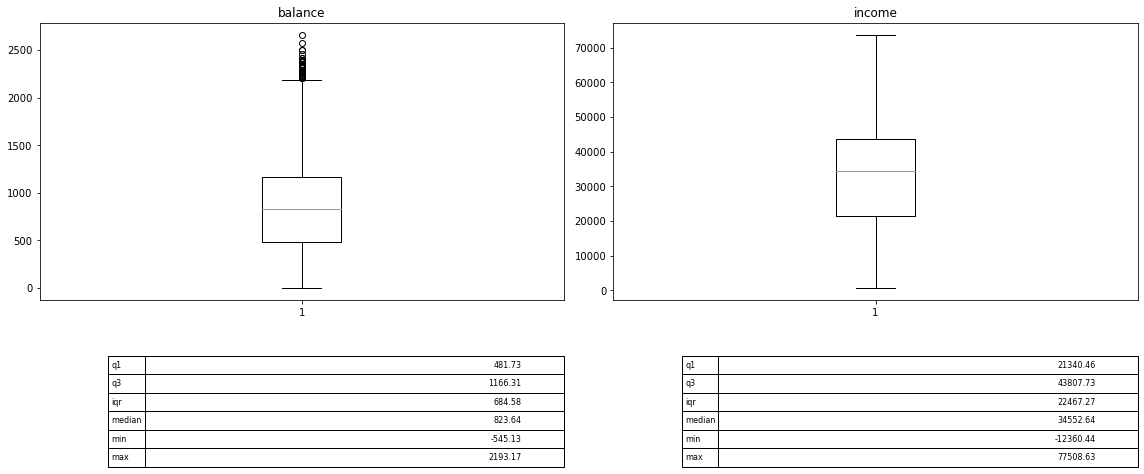

In [5]:
# IQR 관련 값을 주는 함수
def _get_iqr(data):
    """
    :param data: (Series) IQR 계산할 데이터
    :return: (dict) Q1, Q3, IQR, Median, Min, Max 값
    """
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    res = {'q1': q1, 'q3': q3, 'iqr': iqr, 'median': data.median(),
           'min': q1 - (1.5 * iqr), 'max': q3 + (1.5 * iqr)}
    res = {k: round(v, 2) for k, v in res.items()}
    return res

# 박스플롯을 그려주는 함수
def show_box(df, cols):
    """
    :param df: (DataFrame) 박스플롯을 그릴 데이터
    :param cols: (list[str]) 박스플롯을 그릴 데이터의 칼럼들 (수치형 데이터)
    :return: None
    """
    # 연속형 변수 박스플롯 그리기
    fig, axs = plt.subplots(1, len(cols), figsize=[16, 8])
    for i, col in enumerate(cols):
        # 박스플롯 그리기
        axs[i].boxplot(df.loc[:, col])
        axs[i].set_title(col)

        # 테이블 그리기
        iqr_dict = _get_iqr(df[col])
        t = axs[i].table(np.array(list(iqr_dict.values())).reshape(-1, 1),
                         rowLabels=list(iqr_dict.keys()),
                         bbox=[0.2, -0.6, 0.8, 0.4])
        # 테이블 폰트 사이즈 조정
        t.auto_set_font_size(False)
        t.set_fontsize(8)

    fig.tight_layout()
    plt.show()

# 연속형 변수 컬럼
qlt_cols = ['balance', 'income']
show_box(cust_data, qlt_cols)

**해석)**  
> balance 변수의 경우 IQR 상에서 이상치로 볼 수 있는 데이터가 포함되어 있다.

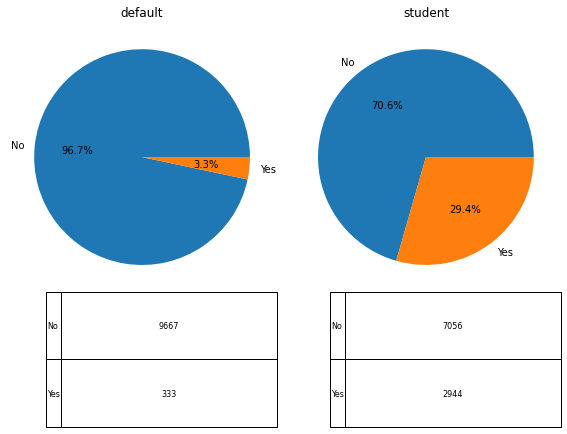

In [6]:
# 파이차트를 그려주는 함수
def show_pie(df, cols, reverse_color=False):
    """
    :param df: (DataFrame) 파이차트를 그릴 데이터
    :param cols: (list[str]) 파이차트를 그릴 데이터의 칼럼들 (수치형 데이터)
    :param reverse_color: (bool) 제목, 라벨, 수치 컬러를 화이트로 할지 여부
    :return: None
    """
    # 범주형 변수 파이차트 그리기
    fig, axs = plt.subplots(1, len(cols), figsize=[8, 6])
    for i, col in enumerate(cols):
        # 카테고리별 개수 내림차순 정렬
        grp_df = df.groupby(by=col).size().sort_values(ascending=False)

        # 파이차트 그리기
        axs[i].pie(grp_df,
                   autopct='%.1f%%',
                   labels=grp_df.index,
                   textprops={'color': "w" if reverse_color is True else 'black'})
        axs[i].set_title(col, color='w' if reverse_color is True else 'black')

        # 테이블 그리기
        t = axs[i].table(np.array(grp_df.values.tolist()).reshape(-1, 1),
                         rowLabels=grp_df.index,
                         bbox=[0.2, -0.5, 0.8, 0.5],
                         cellLoc='center')
        # 테이블 폰트 사이즈 조정
        t.auto_set_font_size(False)
        t.set_fontsize(8)

    fig.tight_layout()
    plt.show()

# 범주형 변수 칼럼
qtt_cols = ['default', 'student']
show_pie(cust_data, qtt_cols, reverse_color=False)

**해석)**  
> 종속변수(y) defalut의 데이터 분포도는 큰 차이를 가지므로 학습, 테스트 데이터의 분할과 학습과정, 테스트 과정 모두 클래스의 불균형이 가져 올 수 있는 문제를 염두에 두어야 하며, 적절한 정제과정이 필요해 보인다.

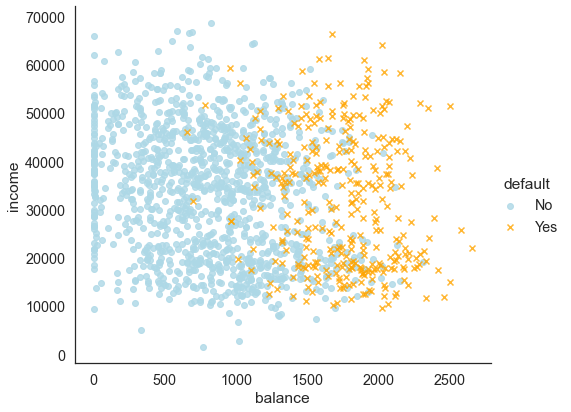

In [7]:
# 1200개 셈플에 대해서 default 값에 따른 income과 balance의 산포도
some_of_No = pd.concat([cust_data.loc[cust_data['default'] == 'No', :].sample(n=1200),  
                        cust_data.loc[cust_data['default'] == 'Yes', :] ], axis=0 )

sns.set(style='white', font_scale=1.3)
def_palette = {'No':'lightblue', 'Yes':'orange'}

sns.lmplot(x='balance', y='income', data=some_of_No, hue='default', fit_reg=False, 
           markers=['o', 'x'], height=6, aspect=1.2, palette=def_palette)

**해석)**  
> 독립변수(x) balance의 변화에 따라 종속변수(y) defalut의 값의 구분이 명확해 보이는 경향이 있으므로, balance는 defalut를 구분 짓는 상관성 높은 변수일 확률이 높다.

<AxesSubplot:xlabel='default', ylabel='income'>

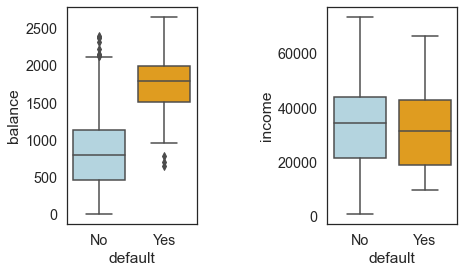

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 4))
fig.subplots_adjust(wspace=1)

sns.boxplot(x='default', y='balance', data=cust_data, orient='v', ax=axs[0], palette=def_palette)
sns.boxplot(x='default', y='income', data=cust_data, orient='v', ax=axs[1], palette=def_palette)

**해석)**  
> 위 산포도와 마찬가지로 balance의 분포는 defalut의 True, False를 구분하는 것에 큰 영향을 미칠 수 있다는 것이 box plot을 통해서도 확인 가능하다.

## 3. PreProcessing

In [10]:
# 데이터 불균형 처리
UNDER_SAMPLING_N = 400
under_sampling_cust_data = pd.concat([cust_data[cust_data['default']=='No'].sample(n=UNDER_SAMPLING_N),
                                      cust_data[cust_data['default']=='Yes']])
under_sampling_cust_data.shape

(733, 4)

In [11]:
# 학습 데이터, 테스트 데이터 분할
train_data, test_data = train_test_split(under_sampling_cust_data, test_size=0.2, random_state=2)
print(train_data.shape)
print(test_data.shape)

(586, 4)
(147, 4)


In [12]:
# 테스트 데이터의 default값 분포 정도 확인
test_data.groupby(by=['default']).size()

default
No     80
Yes    67
dtype: int64

In [13]:
def split_and_dummies(df):
    # 학습 데이터의 독립변수(X) 더미 데이터화
    X = df[df.columns.difference(['default'])].copy()
    X['student'] = X['student'].apply(lambda x: 1 if x.strip() == 'Yes' else 0)
    X = pd.get_dummies(X)

    # 학습 데이터의 종속변수(y) 정수 인코딩
    y = df[['default']].copy()
    y['default'] = y['default'].apply(lambda x: 1 if x.strip() == 'Yes' else 0)
    
    return X, y

# 모델의 학습 겂 입력을 위해 학습 데이터 셋들 스플릿 및 더미화
X_train, y_train = split_and_dummies(train_data)

# 모델의 테스트 값 입력을 위해 테이터 셋들 스플릿 및 더미화
X_test, y_test = split_and_dummies(test_data)

print('Data Set Shape: ', X_train.shape, y_train.shape)

Data Set Shape:  (586, 3) (586, 1)


## 4. Logistic Regression

Logistic Regression은 종속변수 Y가 범주형(Categorical) 변수일 때 다중 선형 회귀 모델을 그대로 적용할 수 없다는 문제$^{(1) }$를 해결해 준다. Logistic Regression은 0과 1을 분류하는 것이 아니라 1에 속할 확률을 예측하는 것으로 문제를 비틀어 해결한다.    

$^{(1)} $범주형 변수는 숫자가 아무런 의미를 가지지 않는다. 예로, '남성'을 1, '여성'을 0으로 표현한 데이터가 있다고 할때 0과 1 사이의 중간 범주가 없으며 '남성'을 0, '여성'을 1로 바꾼다고 해서 문제가 일어나지 않으므로 범주형 변수 0과 1은 단순히 값의 구분만을 목적으로 한다.

----

**TIP)**  *Odds, Logit, Logistic*    
로지스틱 회귀를 위해서 선형 회귀의 [$-\infty, +\infty$]의 결과값 범위를 [$0, 1$]이 되도록 로짓변환하여 로지스틱 함수를 유도한다.

![img_01](./image/logit_logistic.png)

- Odds(승산) = $\frac{P(A)}{P(A^{c})}$ = $\frac{P(A)}{1-P(A)}$    
: 임의의 사건 A가 발생하지 않을 확률 대비 일어날 확률의 비율을 뜩함
    

- Logit = log(Odds) = $log(\frac{P(A)}{1-P(A)})$    
: Odds가 '0~무한대'의 급격한 기울기 값을 가지는 것을 방지하기 위해 log를 취함    
    

- Logistic fuction = $\frac{1}{1+e^{-x}}$    
: 출력값이 0~1의 값을 가지므로 확률밀도함수 요건을 충족함    

----

In [18]:
# Logistic Regression 객체화
# max_iter: Gradient Descent의 반복 횟수 (default=100)
logit_regr = LogisticRegression(max_iter=200)

# Logistic Regression 학습
# .values: numpy (shape: (n, 1))
# .ravel: numpy (shape: (n,))
# ravel()은 flatten()보다 빠르지만 원래 배열과 메모리를 공유하여 원래 배열 값에 영향을 줌
logit_regr.fit(X_train, y_train.values.ravel())

LogisticRegression(max_iter=200)

In [19]:
# 각 데이터 셋별 정확도 비교
print('Data Set Accuracy Result: ', logit_regr.score(X_test, y_test))

Data Set Accuracy Result:  0.7551020408163265


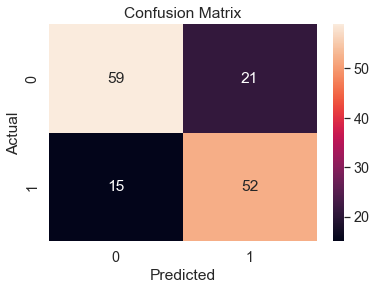


[Confusion Report]

               precision    recall  f1-score   support

           0       0.80      0.74      0.77        80
           1       0.71      0.78      0.74        67

    accuracy                           0.76       147
   macro avg       0.75      0.76      0.75       147
weighted avg       0.76      0.76      0.76       147



In [20]:
def get_confusion_mt(model, _X_test, _y_test):
    y_pred = model.predict(_X_test)
    confusion_mt = pd.crosstab(_y_test.values.ravel(), y_pred, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])
    return confusion_mt

def get_confusion_report(model, _X_test, _y_test):
    y_pred = model.predict(_X_test)
    return classification_report(_y_test, y_pred)

# confusion matrix 산출 
confusion_mt = get_confusion_mt(logit_regr, X_test, y_test)

# confusion matrix 시각화
fig = sns.heatmap(confusion_mt, annot=True, fmt='d')
fig.set_title('Confusion Matrix')
plt.show()

# 여러 측정지표 확인
print('\n[Confusion Report]\n\n', get_confusion_report(logit_regr, X_test, y_test))

----

**TIP)** *Logistic Regression의 Parameter 추정*

**최대우도 추정법(Maximumn Likelihood Estimates; MLE)**    
    
최대우도 추정법은 모수가 미지의 $\theta$인 확률분포에서 뽑은 표본 $x$들을 바탕으로 $\theta$를 추정하는 기법이며, 이때 우도(likelihood)란 이미 주어진 표본 $x$들에 비추어 봤을 때 모집단의 모수 $\theta$에 대한 추정의 그럴듯한 정도를 뜻한다.

In [30]:
n = 10
X = 7
theta = 0.5

likelihood = np.power(theta, X) * np.power((1-theta), (n-X))
likelihood = round(likelihood, 10)
print(likelihood)

0.0009765625


In [29]:
10 * likelihood + 7 * likelihood

0.0166015625